# Artificial Neural Network from scratch

## Objective
To build a 2 layer neural network for a classification problem using objects (classes) in python. This would help in building a strong intuition behind the working of neural nets along with the mathematics. It also helps in experimenting arbitrary architectures like dropout, regularization, bias units and many more by acting as a good starting point. Eventually, as we move more and more towards popular and powerful frameworks like TensorFlow and Keras with black box implementations this exercise seeks to provide a good sense of computations happening in these libraries while implementing more complex networks like CNN, RNN etc.    

## Architecture
* Input layer with 9 inputs since the dataset has 9 features
* Hidden layer with 15 neurons and ReLU activation
* Single neuron output layer with sigmoid activation & binary cross entropy loss

## Dataset 
Cancer dataset is used from the UCI machine learning [repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29)

In [40]:
# Import the required packages
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split

### Load and preprocess data

In [56]:
# Load data
df = pd.read_csv('cancer_data.csv', header = None)
df.head(5)

# Recode the outcomes(y) as 0 & 1
df.iloc[:,10].replace(2, 0,inplace=True)
df.iloc[:,10].replace(4, 1,inplace=True)

# remove rows with ? in column 6
df = df[df[6] != '?']

# Type cast for all columns to be handled as float
df = df.astype(float)

# Scale/ normalize the columns before training/testing
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,1:10]) 
scaled_df = pd.DataFrame(scaled_df, columns = df.columns[1:10])

# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(scaled_df, df[10], test_size=0.2)

# Convert these dataframes into np arrays with the right shape
X_train = np.array(X_train).T
y_train = np.array(y_train).reshape(y_train.shape[0], 1).T
X_test = np.array(X_test).T
y_test = np.array(y_test).reshape(y_test.shape[0], 1).T

In [133]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9, 546)
(1, 546)
(9, 137)
(1, 137)


### Whole Computation Yt = a2 = Sigmoid(w2 ReLU (w1 x+ b1) + b2 )

In [200]:
# Initialize the class and instance variables & functions

class neuralnet:
    
    def __init__(self, xin, yin, num_neuron=15, learning_rate=0.003, epoch=2000):
        
        self.x = xin
        self.y = yin
        self.yt = np.zeros((1, self.y.shape[1]))
                           
        # Create a dictionary to hold parameters - weights & biases
        self.weight_bias = defaultdict()
        self.lr = learning_rate # get user input for learning rate
        self.loss = [] # store losses in each epoch
        
        # Dictionary to store all intermediate computations and differentials
        self.inter = defaultdict()
                           
        # neural_net dimensions
        self.nn_dims = [self.x.shape[0], num_neuron, 1] # Layer wise dimensions (9, 15, 1)
        
        # Number of passes/epochs
        self.epoch = epoch

        
    def initialize(self):
        
        # Initialize weights and biases
        self.weight_bias['w1'] = np.random.randn(self.nn_dims[0], self.nn_dims[1])/np.sqrt(self.nn_dims[0]) # (9, 15)
        self.weight_bias['b1'] = np.zeros((self.nn_dims[1], 1)) # (15, 1)
        
        self.weight_bias['w2'] = np.random.randn(self.nn_dims[1], 1)/np.sqrt(self.nn_dims[1]) #(15, 1)
        self.weight_bias['b2'] = np.zeros((1, 1))  
                           
        
    def relu(self, z):
        return np.maximum(0,z)
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def loss_fwd_pass(self, yt):
        loss_pass = (-1/self.x.shape[1])*(np.dot(self.y, np.log(yt).T) + np.dot((1-self.y), np.log(1-yt).T))
        return loss_pass
        
    
    def forward_prop(self): 
        
        self.inter['z1'] = np.dot(self.weight_bias['w1'].T, self.x) + self.weight_bias['b1']
        self.inter['a1'] = self.relu(self.inter['z1'])
        self.inter['z2'] = np.dot(self.weight_bias['w2'].T, self.inter['a1']) + self.weight_bias['b2']
        self.inter['a2'] = self.sigmoid(self.inter['z2'])
        self.yt = self.inter['a2']
        
        # Calculate Loss
        loss_this_pass = self.loss_fwd_pass(self.yt)
        
        return self.yt, loss_this_pass[0][0]
        
        
    def drelu(self, z):
        z[z<=0] = 0
        z[z>0] = 1
        return z

    
    def backward_prop(self):
        
        self.inter['dyt'] = -np.divide(self.y, self.yt) + np.divide(1-self.y, 1-self.yt) 
        self.inter['dz2'] = self.yt - self.y # (1, 200)
        self.inter['da1'] = np.dot(self.weight_bias['w2'], self.inter['dz2']) # (15, 200)
        self.inter['dw2'] = (np.dot(self.inter['a1'], self.inter['dz2'].T))/self.inter['a1'].shape[1] # (15, 1)
        self.inter['db2'] = np.dot(self.inter['dz2'], np.ones((self.inter['dz2'].shape[1], 1)))/self.inter['dz2'].shape[1]
        self.inter['dz1'] = self.inter['da1'] * self.drelu(self.inter['z1']) #(15, 200)
        self.inter['dw1'] = np.dot(self.x, self.inter['dz1'].T)/self.inter['dz1'].shape[1]
        self.inter['db1'] = np.dot(self.inter['dz1'], np.ones((self.inter['dz1'].shape[1], 1)))/self.inter['dz1'].shape[1]# (15, 1)
        
        # Update the weights
        self.weight_bias['w1'] = self.weight_bias['w1'] - self.lr * self.inter['dw1']
        self.weight_bias['b1'] = self.weight_bias['b1'] - self.lr * self.inter['db1']
        self.weight_bias['w2'] = self.weight_bias['w2'] - self.lr * self.inter['dw2']
        self.weight_bias['b2'] = self.weight_bias['b2'] - self.lr * self.inter['db2']
        

    def train_nn(self):

        # Set seed
        np.random.seed(221)
        
        # Initialize weights
        self.initialize()
        
        for i in range(0, self.epoch):
            yt_pass, loss_one_pass = self.forward_prop()
            self.loss.append(loss_one_pass) # track losses for each pass
            self.backward_prop()
            



### Setup the network & learning rate and train the network 

In [201]:
nn = neuralnet(X_train,y_train)
nn.lr = 0.01
nn.train_nn()

### Plot training loss for 2000 epochs

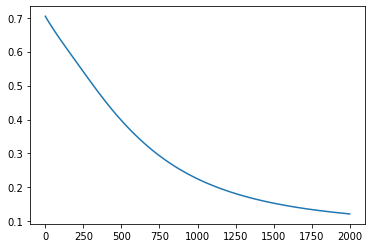

In [202]:
plt.plot(nn.loss)

In [210]:
# Predicted output
nn.yt

array([[1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 

In [206]:
# True output
nn.y

array([[1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 

### Generate the confusion matrix keeping the threshold to be 0.5

In [224]:
nn.yt[nn.yt>=0.5] = 1
nn.yt[nn.yt<0.5] = 0
confusion_matrix(list(nn.y[0]), list(nn.yt[0]))

array([[347,   9],
       [  8, 182]])

### Accuracy from the confusion matrix above

In [225]:
(347+182)/(347+182+17)

0.9688644688644689